In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

## Read Data

In [33]:
data = pd.read_csv('../src/data/train.csv')
print(data.shape)
data.head()

(19158, 14)


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


- **enrollee_id:** Unique ID for candidate
- **city:** City code
- **city_development_index:** Developement index of the city (scaled)
- **gender:** Gender of candidate
- **relevent_experience:** Relevant experience of candidate
- **enrolled_university:** Type of University course enrolled if any
- **education_level:** Education level of candidate
- **major_discipline:** Education major discipline of candidate
- **experience:** Candidate total experience in years
- **company_size:** No of employees in current employer's company
- **company_type:** Type of current employer
- **lastnewjob:** Difference in years between previous job and current job
- **training_hours:** training hours completed
- **target:** 0 – Not looking for job change, 1 – Looking for a job change

## Data Types

In [34]:
data.drop('enrollee_id', axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    19158 non-null  object 
 1   city_development_index  19158 non-null  float64
 2   gender                  14650 non-null  object 
 3   relevent_experience     19158 non-null  object 
 4   enrolled_university     18772 non-null  object 
 5   education_level         18698 non-null  object 
 6   major_discipline        16345 non-null  object 
 7   experience              19093 non-null  object 
 8   company_size            13220 non-null  object 
 9   company_type            13018 non-null  object 
 10  last_new_job            18735 non-null  object 
 11  training_hours          19158 non-null  int64  
 12  target                  19158 non-null  float64
dtypes: float64(2), int64(1), object(10)
memory usage: 1.9+ MB


### Categorical Variables

In [35]:
target = 'target'
cat_vars = [var for var in data.columns if data[var].dtype == 'O']
print(len(cat_vars))
cat_vars

10


['city',
 'gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

In [54]:
data[cat_vars].nunique()

city                   123
gender                   3
relevent_experience      2
enrolled_university      3
education_level          5
major_discipline         6
experience              22
company_size             8
company_type             6
last_new_job             6
dtype: int64

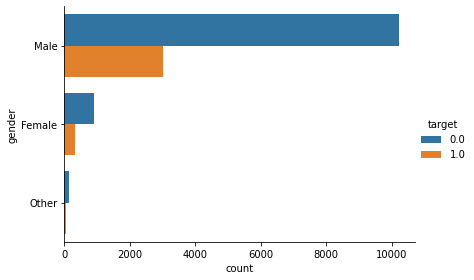

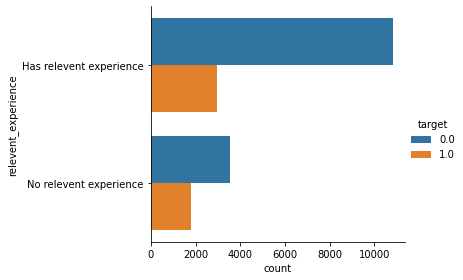

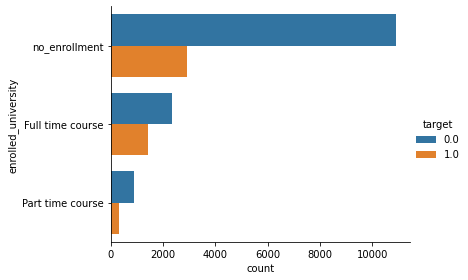

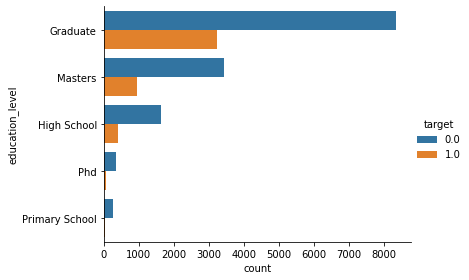

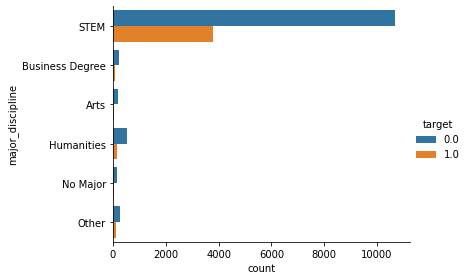

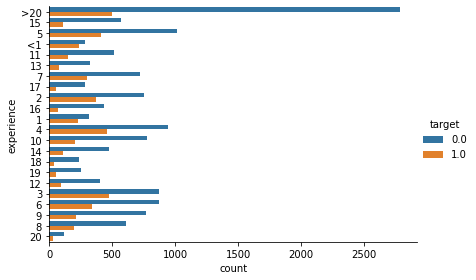

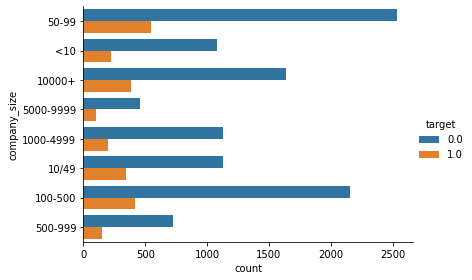

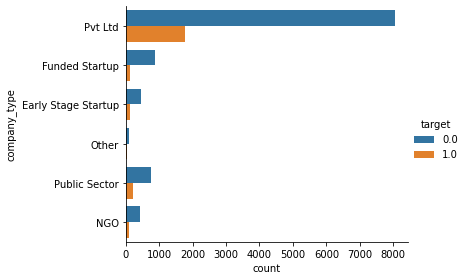

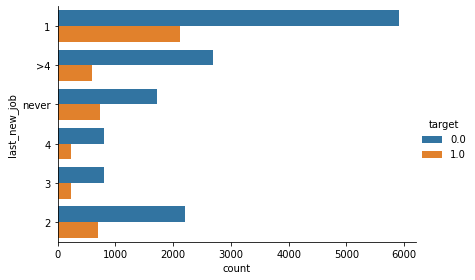

In [56]:
for var in [c for c in cat_vars if 'city' not in c]:
    # make boxplot with Catplot
    sns.catplot(y=var, hue=target, data=data, kind="count", height=4, aspect=1.5)
    plt.show()

### Numerical Variables

In [36]:
num_vars = [var for var in data.columns if var not in cat_vars and var != target]
print(len(num_vars))
num_vars

2


['city_development_index', 'training_hours']

In [70]:
data[num_vars].describe()

,city_development_index,training_hours
count,19158.000000,19158.000000
mean,0.828848,65.366896
std,0.123362,60.058462
min,0.448000,1.000000
25%,0.740000,23.000000
50%,0.903000,47.000000
75%,0.920000,88.000000
max,0.949000,336.000000


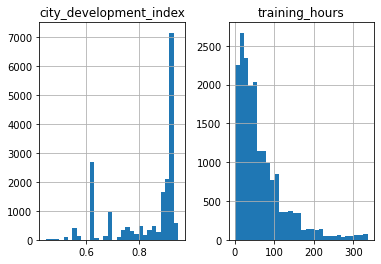

In [58]:
data[num_vars].hist(bins=30)
plt.show()

#### Yeo-Johnson transformation

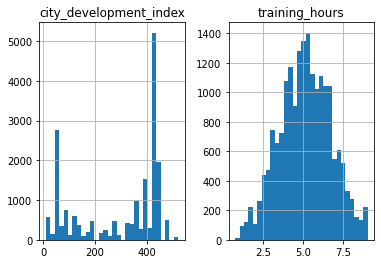

In [63]:
tmp = data.copy()

for var in num_vars:

    # transform the variable - yeo-johsnon
    tmp[var], param = stats.yeojohnson(data[var])
    
# plot the histograms of the transformed variables
tmp[num_vars].hist(bins=30)
plt.show()

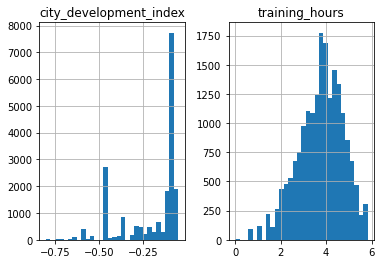

In [72]:
tmp = data.copy()

for var in num_vars:

    # transform the variable - log
    tmp[var] = np.log(data[var])
    
# plot the histograms of the transformed variables
tmp[num_vars].hist(bins=30)
plt.show()

#### Log Transformation

## Missing Values

In [37]:
vars_with_na = [var for var in data.columns if data[var].isnull().sum() > 0]

# percentage of missing values for cols with na
data[vars_with_na].isnull().mean().sort_values(ascending=False)

company_type           0.320493
company_size           0.309949
gender                 0.235306
major_discipline       0.146832
education_level        0.024011
last_new_job           0.022080
enrolled_university    0.020148
experience             0.003393
dtype: float64

In [38]:
def analyse_na_value(df, var, target):
    '''
    compare the median SalePrice in the observations where data 
    is missing vs the observations where data is available
    '''
    df = df.copy()
    
    # an interim variable that indicates 1 if the observation was missing or 0 otherwise
    df[var] = np.where(df[var].isnull(), 1, 0)
    
    tmp = df.groupby(var)[target].agg(['mean', 'std'])
    
    tmp.plot(kind="barh", y="mean", legend=False,
             xerr="std", title="Looking for a job change", color='orange')

    plt.show()

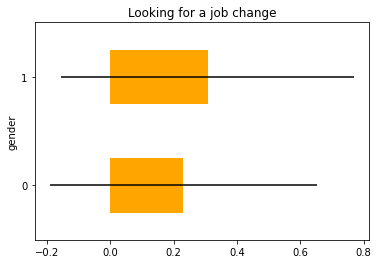

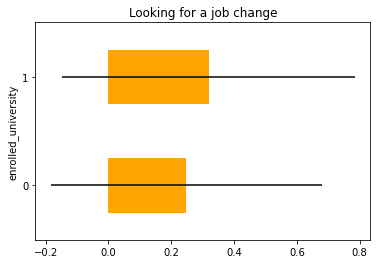

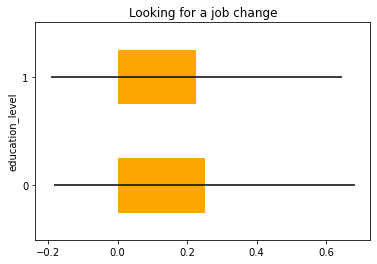

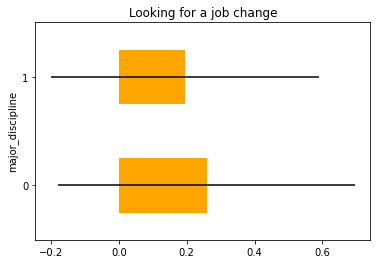

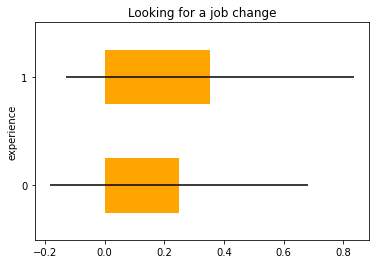

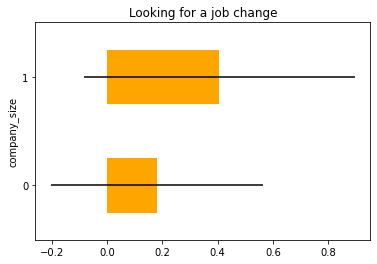

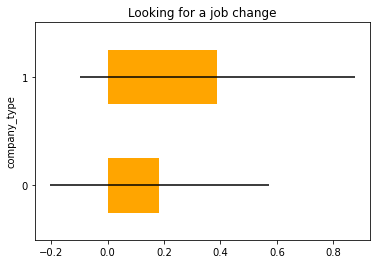

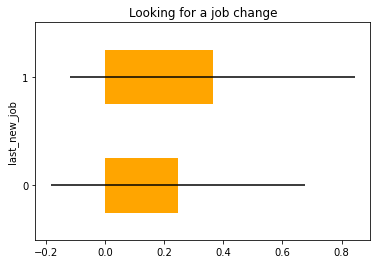

In [39]:
for var in vars_with_na:
    analyse_na_value(data, var, target)

Where there is difference, it suggests that missing data could be a good predictor.

## Categorical Variables Transformation

In [76]:
def analyse_rare_labels(df, var, target, rare_perc):
    df = df.copy()

    # determine the % of observations per category
    tmp = df.groupby(var)[target].count() / len(df)

    # return categories that are rare
    return tmp[tmp < rare_perc]

# print categories that are present in less than 1 % of the observations

for var in cat_vars:
    print(analyse_rare_labels(data, var, target, 0.01))
    print('='*40)

city
city_1      0.001357
city_10     0.004489
city_101    0.003915
city_105    0.004124
city_106    0.000470
              ...   
city_93     0.001357
city_94     0.001357
city_97     0.005429
city_98     0.004124
city_99     0.004907
Name: target, Length: 106, dtype: float64
gender
Other    0.00997
Name: target, dtype: float64
Series([], Name: target, dtype: float64)
Series([], Name: target, dtype: float64)
Series([], Name: target, dtype: float64)
Series([], Name: target, dtype: float64)
experience
20    0.007725
Name: target, dtype: float64
Series([], Name: target, dtype: float64)
company_type
Other    0.006316
Name: target, dtype: float64
Series([], Name: target, dtype: float64)


Labels that are under-represented in the dataset tend to cause over-fitting of machine learning models.